<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Chess Game Playing While Chitchatting by GPT-4 Agents

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is modified based on https://github.com/ekzhu/FLAML/blob/evaluation/evaluation/chess/play_chess.ipynb

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
%%capture --no-stderr
# %pip install pyautogen~=0.1.0
%pip install chess -U

In [2]:
import chess
import chess.svg

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [3]:
import autogen

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)
# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": {
#             "gpt-3.5-turbo",
#             "gpt-3.5-turbo-16k",
#             "gpt-3.5-turbo-16k-0613",
#             "gpt-3.5-turbo-0301",
#             "chatgpt-35-turbo-0301",
#             "gpt-35-turbo-v0301",
#         },
#     },
# )

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choosing "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Define Agents

We'll define a BoardAgent and a ChessPlayerAgent class.

In [4]:
from collections import defaultdict
from typing import Any, Dict, List, Optional, Union

sys_msg = """You are an AI-powered chess board agent.
You translate the user's natural language input into legal UCI moves.
You should only reply with a UCI move string extracted from the user's input."""

class BoardAgent(autogen.AssistantAgent):
    board: chess.Board
    correct_move_messages: Dict[autogen.Agent, List[Dict]]

    def __init__(self, board: chess.Board):
        super().__init__(
            name="BoardAgent",
            system_message=sys_msg,
            llm_config={"temperature": 0.0, "config_list": config_list_gpt4},
            max_consecutive_auto_reply=10,
        )
        self.register_reply(autogen.ConversableAgent, BoardAgent._generate_board_reply)
        self.board = board
        self.correct_move_messages = defaultdict(list)

    def _generate_board_reply(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[Any] = None,
    ) -> Union[str, Dict, None]:
        message = messages[-1]
        # extract a UCI move from player's message
        reply = self.generate_reply(self.correct_move_messages[sender] + [message], sender, exclude=[BoardAgent._generate_board_reply])
        uci_move = reply if isinstance(reply, str) else str(reply["content"])
        try:
            self.board.push_uci(uci_move)
        except ValueError as e:
            # invalid move
            return True, f"Error: {e}"
        else:
            # valid move
            m = chess.Move.from_uci(uci_move)
            display(chess.svg.board(self.board, arrows=[(m.from_square, m.to_square)], fill={m.from_square: "gray"}, size=200))
            self.correct_move_messages[sender].extend([message, self._message_to_dict(uci_move)])
            self.correct_move_messages[sender][-1]["role"] = "assistant"
            return True, uci_move


In [5]:
sys_msg_tmpl = """Your name is {name} and you are a chess player. 
You are playing against {opponent_name}. 
You are playing as {color}. 
You communicate your move using universal chess interface language.
You also chit-chat with your opponent when you communicate a move to light up the mood.
You should ensure both you and the opponent are making legal moves.
Do not apologize for making illegal moves."""


class ChessPlayerAgent(autogen.AssistantAgent):

    def __init__(
        self,
        color: str,
        board_agent: BoardAgent,
        max_turns: int,
        **kwargs,
    ):
        if color not in ["white", "black"]:
            raise ValueError(f"color must be either white or black, but got {color}")
        opponent_color = "black" if color == "white" else "white"
        name = f"Player {color}"
        opponent_name = f"Player {opponent_color}"
        sys_msg = sys_msg_tmpl.format(
            name=name,
            opponent_name=opponent_name,
            color=color,
        )
        super().__init__(
            name=name,
            system_message=sys_msg,
            max_consecutive_auto_reply=max_turns,
            **kwargs,
        )
        self.register_reply(BoardAgent, ChessPlayerAgent._generate_reply_for_board, config=board_agent.board)
        self.register_reply(ChessPlayerAgent, ChessPlayerAgent._generate_reply_for_player, config=board_agent)
        self.update_max_consecutive_auto_reply(board_agent.max_consecutive_auto_reply(), board_agent)

    def _generate_reply_for_board(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[chess.Board] = None,
    ) -> Union[str, Dict, None]:
        board = config
        # add a system message about the current state of the board.
        board_state_msg = [{"role": "system", "content": f"Current board:\n{board}"}]
        last_message = messages[-1]
        if last_message["content"].startswith("Error"):
            # try again
            last_message["role"] = "system"
            return True, self.generate_reply(messages + board_state_msg, sender, exclude=[ChessPlayerAgent._generate_reply_for_board])
        else:
            return True, None

    def _generate_reply_for_player(
        self,
        messages: Optional[List[Dict]] = None,
        sender: Optional[autogen.Agent] = None,
        config: Optional[BoardAgent] = None,
    ) -> Union[str, Dict, None]:
        board_agent = config
        # add a system message about the current state of the board.
        board_state_msg = [{"role": "system", "content": f"Current board:\n{board_agent.board}"}]
        # propose a reply which will be sent to the board agent for verification.
        message = self.generate_reply(messages + board_state_msg, sender, exclude=[ChessPlayerAgent._generate_reply_for_player])
        if message is None:
            return True, None
        # converse with the board until a legal move is made or max allowed retries.
        # change silent to False to see that conversation.
        self.initiate_chat(board_agent, clear_history=False, message=message, silent=self.human_input_mode == "NEVER")
        # last message sent by the board agent
        last_message = self._oai_messages[board_agent][-1]
        if last_message["role"] == "assistant":
            # didn't make a legal move after a limit times of retries.
            print(f"{self.name}: I yield.")
            return True, None
        return True, self._oai_messages[board_agent][-2]


## Construct Agents

In [6]:
max_turn = 10

board = chess.Board()
board_agent = BoardAgent(board=board)
player_black = ChessPlayerAgent(
    color="black",
    board_agent=board_agent,
    max_turns=max_turn,
    llm_config={"temperature": 0.5, "seed": 1, "config_list": config_list_gpt4},
)
player_white = ChessPlayerAgent(
    color="white",
    board_agent=board_agent,
    max_turns=max_turn,
    llm_config={"temperature": 0.5, "seed": 2, "config_list": config_list_gpt4},
)

## Start Game

Player black (to Player white):

Your turn.

--------------------------------------------------------------------------------


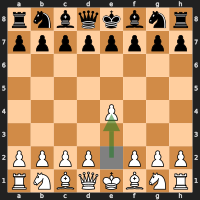

Player white (to Player black):

Alright, let's get this game started! I'll move my pawn from e2 to e4. Your move, Player black!

--------------------------------------------------------------------------------


KeyboardInterrupt: 

In [7]:
player_black.initiate_chat(player_white, message="Your turn.")